In [0]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from google.colab import drive
import sys, os, shutil
from pathlib import Path
drive.mount("/content/drive", force_remount=True)
colabase = Path('/content/drive/My Drive/Colab Notebooks/')
course = Path('/content/drive/My Drive/course-v3/')
dlff = Path('/content/drive/My Drive/deeplearning-ff/')
#sys.path.append(str(dlff)) # cd {dlff}
os.chdir(dlff)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#export
from exports.lg_06 import *

## ConvNet



Let's get the data and training interface from where we left in the last notebook.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=5899)

In [0]:
x_train,y_train,x_valid,y_valid = get_data()

x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [0]:
mnist_view = view_tfm(1,28,28)
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, mnist_view)]

In [0]:
nfs = [8,16,32,64,64]

In [0]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [11]:
%time run.fit(2, learn)

train: [1.046752578125, tensor(0.6619, device='cuda:0')]
valid: [0.2372855712890625, tensor(0.9347, device='cuda:0')]
train: [0.1495285546875, tensor(0.9546, device='cuda:0')]
valid: [0.1055251708984375, tensor(0.9667, device='cuda:0')]
CPU times: user 4.78 s, sys: 1.87 s, total: 6.65 s
Wall time: 9.64 s


## Batchnorm

### Custom

Let's start by building our own `BatchNorm` layer from scratch.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=6018)

In [0]:
#export
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect 
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1)) # learnable
        self.adds  = nn.Parameter(torch.zeros(nf,1,1)) # learnable
        self.register_buffer('vars',  torch.ones(1,nf,1,1)) # if we move model to gpu, will move along
        self.register_buffer('means', torch.zeros(1,nf,1,1)) # saved allong with model, to use at inference

    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True) # avg across batch, H and W;only channel dimension left
        v = x.var ((0,2,3), keepdim=True) # but keepdim, so stays in shape with lots of same numbers
        self.means.lerp_(m, self.mom) # running avg, using just last two
        self.vars.lerp_ (v, self.mom) # 'linear interp', here mom * now + (1-mom)* past
        return m,v
        
    def forward(self, x):
        if self.training:#normalize with current stats during traing
            with torch.no_grad(): m,v = self.update_stats(x) 
        else: m,v = self.means,self.vars # just use running avg at inference
        x = (x-m) / (v+self.eps).sqrt() # normalize
        return x*self.mults + self.adds # scale and shift, not more need for bias in cov layers

In [0]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    # No bias needed if using bn
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)

In [0]:
#export
def init_cnn_(m, f): # init recursively
    if isinstance(m, nn.Conv2d):
        f(m.weight, a=0.1)
        if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
    for l in m.children(): init_cnn_(l, f) # init recursively

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)

def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

We can then use it in training and see how it helps keep the activations means to 0 and the std to 1.

In [0]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs)

train: [0.29165505859375, tensor(0.9097, device='cuda:0')]
valid: [0.194936376953125, tensor(0.9365, device='cuda:0')]


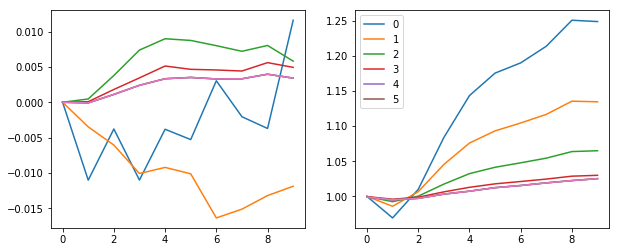

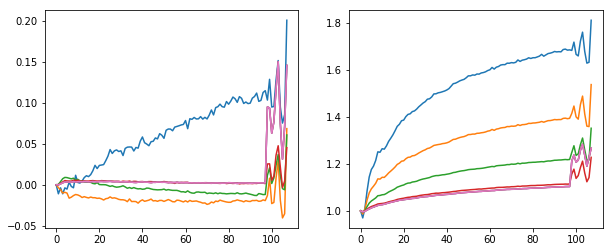

In [17]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
# all graphs ( all layaers acts) start at mean=0 std =1 

In [0]:
learn,run = get_learn_run(nfs, data, 1.0, conv_layer, cbs=cbfs)

In [19]:
%time run.fit(3, learn)

train: [0.2501879296875, tensor(0.9216, device='cuda:0')]
valid: [0.1038783447265625, tensor(0.9685, device='cuda:0')]
train: [0.0874494921875, tensor(0.9728, device='cuda:0')]
valid: [0.081936083984375, tensor(0.9758, device='cuda:0')]
train: [0.0633875732421875, tensor(0.9803, device='cuda:0')]
valid: [0.115921044921875, tensor(0.9656, device='cuda:0')]
CPU times: user 4.61 s, sys: 1.49 s, total: 6.1 s
Wall time: 6.14 s


### Builtin batchnorm - Pytorch

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=6679)

In [0]:
#export
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [0]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs)

In [22]:
%time run.fit(3, learn)

train: [0.27987380859375, tensor(0.9153, device='cuda:0')]
valid: [0.12453408203125, tensor(0.9605, device='cuda:0')]
train: [0.0758426513671875, tensor(0.9771, device='cuda:0')]
valid: [0.09398897705078126, tensor(0.9717, device='cuda:0')]
train: [0.05301892578125, tensor(0.9839, device='cuda:0')]
valid: [0.08318557739257812, tensor(0.9759, device='cuda:0')]
CPU times: user 4.34 s, sys: 1.53 s, total: 5.87 s
Wall time: 5.9 s


### With scheduler

Now let's add the usual warm-up/annealing.

In [0]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.6, 2.), sched_lin(2., 0.1)]) 

In [0]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched)])

In [26]:
run.fit(8, learn) # we can go up to lr of 2, with run-up of 0.3 only and still get 99%

train: [0.3191480859375, tensor(0.9059, device='cuda:0')]
valid: [0.101096044921875, tensor(0.9699, device='cuda:0')]
train: [0.11049115234375, tensor(0.9672, device='cuda:0')]
valid: [39.580128125, tensor(0.0819, device='cuda:0')]
train: [0.2295929296875, tensor(0.9330, device='cuda:0')]
valid: [0.10195521240234375, tensor(0.9684, device='cuda:0')]
train: [0.0604672216796875, tensor(0.9814, device='cuda:0')]
valid: [0.05758358764648437, tensor(0.9812, device='cuda:0')]
train: [0.0415012548828125, tensor(0.9868, device='cuda:0')]
valid: [0.04848540954589844, tensor(0.9869, device='cuda:0')]
train: [0.0297352783203125, tensor(0.9907, device='cuda:0')]
valid: [0.04662535095214844, tensor(0.9860, device='cuda:0')]
train: [0.02202110107421875, tensor(0.9936, device='cuda:0')]
valid: [0.04601910400390625, tensor(0.9866, device='cuda:0')]
train: [0.017482415771484374, tensor(0.9953, device='cuda:0')]
valid: [0.04332135009765625, tensor(0.9877, device='cuda:0')]


## More norms

### Layer norm

From [the paper](https://arxiv.org/abs/1607.06450): "*batch normalization **cannot be applied to online learning tasks** or to extremely large distributed models where the* **minibatches have to be small**".

In [0]:
# small bs = risk for std=0 so division by zero. or by too small epsilone
# other weakness is unclear how you apply batchnorm to RNN (see video 1:53:00) whats the running avg

General equation for a norm layer with learnable affine:

$$y = \frac{x - \mathrm{E}[x]}{ \sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta$$

The difference with BatchNorm is
1. we don't keep a moving average
2. we don't average over the batches dimension but over the hidden dimension, so it's independent of the batch size

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=6717)

In [0]:
#export
class LayerNorm(nn.Module):# avg accross filters, H W, only batch dim stays
    # good workaround for RNN, but not so great for rest
    # u r not differentiating channels ( or normalizing them separately)
    __constants__ = ['eps']
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add  = nn.Parameter(tensor(0.))

    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True) # every img has own mean, std 
        v = x.var ((1,2,3), keepdim=True) # not avg across batch
        x = (x-m) / ((v+self.eps).sqrt()) # so no concept of running avg
        return x*self.mult + self.add

In [0]:
def conv_ln(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(LayerNorm())
    return nn.Sequential(*layers)

In [0]:
learn,run = get_learn_run(nfs, data, 0.8, conv_ln, cbs=cbfs)

In [41]:
%time run.fit(3, learn)

train: [nan, tensor(0.1325, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
CPU times: user 5.53 s, sys: 1.65 s, total: 7.18 s
Wall time: 7.21 s


*Thought experiment*: can this distinguish foggy days from sunny days (assuming you're using it before the first conv)?

In [0]:
# No, with layer norm. mean = brghtness, std = contrast. Foggy= low mean, low contrast
# u are avging activations across channels with Layer norm so all means same, all std same, cant distinguish
# ur trhowing away learned info..

### Instance norm

From [the paper](https://arxiv.org/abs/1607.08022): 

The key difference between **contrast** and batch normalization is that the latter applies the normalization to a  whole batch of images instead for single ones:

\begin{equation}\label{eq:bnorm}
    y_{tijk} =  \frac{x_{tijk} - \mu_{i}}{\sqrt{\sigma_i^2 + \epsilon}},
    \quad
    \mu_i = \frac{1}{HWT}\sum_{t=1}^T\sum_{l=1}^W \sum_{m=1}^H x_{tilm},
    \quad
    \sigma_i^2 = \frac{1}{HWT}\sum_{t=1}^T\sum_{l=1}^W \sum_{m=1}^H (x_{tilm} - mu_i)^2.
\end{equation}

In order to combine the effects of instance-specific normalization and batch normalization, we propose to replace the latter by the *instance normalization* (also known as *contrast normalization*) layer:

\begin{equation}\label{eq:inorm}
    y_{tijk} =  \frac{x_{tijk} - \mu_{ti}}{\sqrt{\sigma_{ti}^2 + \epsilon}},
    \quad
    \mu_{ti} = \frac{1}{HW}\sum_{l=1}^W \sum_{m=1}^H x_{tilm},
    \quad
    \sigma_{ti}^2 = \frac{1}{HW}\sum_{l=1}^W \sum_{m=1}^H (x_{tilm} - mu_{ti})^2.
\end{equation}

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=7114)

In [0]:
#export
class InstanceNorm(nn.Module): # avg accross H W only
    #designed for style transfer not classification 
    __constants__ = ['eps']
    def __init__(self, nf, eps=1e-0):
        super().__init__()
        self.eps = eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))

    def forward(self, x):
        m = x.mean((2,3), keepdim=True) # avg accross H W only
        v = x.var ((2,3), keepdim=True) # avg accross H W only
        res = (x-m) / ((v+self.eps).sqrt())
        return res*self.mults + self.adds

In [0]:
def conv_in(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(InstanceNorm(nf))
    return nn.Sequential(*layers)

In [0]:
learn,run = get_learn_run(nfs, data, 0.1, conv_in, cbs=cbfs)

In [48]:
%time run.fit(3, learn)

train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
CPU times: user 5.7 s, sys: 1.8 s, total: 7.5 s
Wall time: 7.53 s


*Question*: why can't this classify anything?

Lost in all those norms? The authors from the [group norm paper](https://arxiv.org/pdf/1803.08494.pdf) have you covered:

![Various norms](images/norms.png)

### Group norm

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=7213)

*From the PyTorch docs:*

`GroupNorm(num_groups, num_channels, eps=1e-5, affine=True)`

The input channels are separated into `num_groups` groups, each containing
``num_channels / num_groups`` channels. The mean and standard-deviation are calculated
separately over the each group. $\gamma$ and $\beta$ are learnable
per-channel affine transform parameter vectorss of size `num_channels` if
`affine` is ``True``.

This layer uses statistics computed from input data in both training and
evaluation modes.

Args:
-    num_groups (int): number of groups to separate the channels into
-    num_channels (int): number of channels expected in input
-    eps: a value added to the denominator for numerical stability. Default: 1e-5
-    affine: a boolean value that when set to ``True``, this module
        has learnable per-channel affine parameters initialized to ones (for weights)
        and zeros (for biases). Default: ``True``.

Shape:
- Input: `(N, num_channels, *)`
- Output: `(N, num_channels, *)` (same shape as input)

Examples::

    >>> input = torch.randn(20, 6, 10, 10)
    >>> # Separate 6 channels into 3 groups
    >>> m = nn.GroupNorm(3, 6)
    >>> # Separate 6 channels into 6 groups (equivalent with InstanceNorm)
    >>> m = nn.GroupNorm(6, 6)
    >>> # Put all 6 channels into a single group (equivalent with LayerNorm)
    >>> m = nn.GroupNorm(1, 6)
    >>> # Activating the module
    >>> output = m(input)

## Fix small batch sizes

### What's the problem?

When we compute the statistics (mean and std) for a BatchNorm Layer on a small batch, it is possible that we get a standard deviation very close to 0. because there aren't many samples (the variance of one thing is 0. since it's equal to its mean).

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=7304)

In [0]:
data = DataBunch(*get_dls(train_ds, valid_ds, 2), c)

In [0]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [0]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [52]:
%time run.fit(1, learn) # very long as small batch

train: [2.33265953125, tensor(0.1886, device='cuda:0')]
valid: [879429.12, tensor(0.2855, device='cuda:0')]
CPU times: user 1min 46s, sys: 2.79 s, total: 1min 49s
Wall time: 1min 50s


In [0]:
# we could use higher epsilon to avoid zero division, even make epsilon learnable

### Running Batch Norm

To solve this problem we introduce a Running BatchNorm that uses smoother running mean and variance for the mean and std.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=7516)

In [0]:
#export
class RunningBatchNorm(nn.Module):
    """We normalize by running moving avg, all the time, not just inference
    We use E[X^2] - E[X]^2, not averaging Var[X] """ # detail #1 
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('sums', torch.zeros(1,nf,1,1)) #keeps buffer 
        self.register_buffer('sqrs', torch.zeros(1,nf,1,1))
        self.register_buffer('batch', tensor(0.))
        self.register_buffer('count', tensor(0.)) # to adjust if bs iregular bs, detail #2
        self.register_buffer('step', tensor(0.))
        self.register_buffer('dbias', tensor(0.))

    def update_stats(self, x):
        bs,nc,*_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0,2,3)
        s = x.sum(dims, keepdim=True)
        ss = (x*x).sum(dims, keepdim=True)
        c = self.count.new_tensor(x.numel()/nc) #bs*H*W ; what to divide sums, sqrs by #2
        mom1 = 1 - (1-self.mom)/math.sqrt(bs-1)
        self.mom1 = self.dbias.new_tensor(mom1)
        self.sums.lerp_(s, self.mom1)
        self.sqrs.lerp_(ss, self.mom1)
        self.count.lerp_(c, self.mom1)
        self.dbias = self.dbias*(1-self.mom1) + self.mom1
        self.batch += bs
        self.step += 1

    def forward(self, x):
        if self.training: self.update_stats(x) # only update stats in training
        sums = self.sums #update sums, sqrs and count to calc mvg avg
        sqrs = self.sqrs 
        c = self.count
        if self.step<100:
            sums = sums / self.dbias # adjust for high influence of 1st points (zeros) in the mvg avg overtime
            sqrs = sqrs / self.dbias # detail # 3 
            c    = c    / self.dbias
        means = sums/c  # but use moving avgs to normalize. always, not just inference time
        vars = (sqrs/c).sub_(means*means) # so no way affected in case latest mean or std is zero
        if bool(self.batch < 20): vars.clamp_min_(0.01) #avoid bad luck of very 1st points being zero
        x = (x-means).div_((vars.add_(self.eps)).sqrt())
        return x.mul_(self.mults).add_(self.adds)

In [0]:
def conv_rbn(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(RunningBatchNorm(nf))
    return nn.Sequential(*layers)

In [0]:
learn,run = get_learn_run(nfs, data, 0.4, conv_rbn, cbs=cbfs)

In [62]:
%time run.fit(1, learn)

train: [0.4133687890625, tensor(0.8924, device='cuda:0')]
valid: [0.19822415771484375, tensor(0.9625, device='cuda:0')]
CPU times: user 4min 24s, sys: 5.88 s, total: 4min 30s
Wall time: 4min 32s


This solves the small batch size issue!

### What can we do in a single epoch?

Now let's see with a decent batch size what result we can get.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=8068)

In [0]:
data = DataBunch(*get_dls(train_ds, valid_ds, 32), c)

In [0]:
learn,run = get_learn_run(nfs, data, 0.9, conv_rbn, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched_lin(1., 0.2))])

In [65]:
%time run.fit(1, learn)

train: [0.14855734375, tensor(0.9544, device='cuda:0')]
valid: [0.060174725341796874, tensor(0.9835, device='cuda:0')]
CPU times: user 17.4 s, sys: 405 ms, total: 17.8 s
Wall time: 17.9 s


## Export

In [5]:
nb_auto_export()

<IPython.core.display.Javascript object>

In [67]:
!pip install fire
!python notebook2script.py 07_batchnorm.ipynb

     |████████████████████████████████| 81kB 2.8MB/s 
  Created wheel for fire: filename=fire-0.2.1-py2.py3-none-any.whl size=103527 sha256=bdfcc09cd01d8a77a60d8332c2d5b0d621941cdc8291c0ac3d6b023dee16cead
  Stored in directory: /root/.cache/pip/wheels/31/9c/c0/07b6dc7faf1844bb4688f46b569efe6cafaa2179c95db821da
Successfully built fire
Converted 07_batchnorm.ipynb to exports/lg_07.py
